# 국내 여행로그 데이터 분석: 방문객 1인당 소비금액 예측

## 데이터과학개론 조별과제

### 프로젝트 목표
- 방문객 특성(연령대, 성별, 동반자 수, 체류기간)과 지역 정보를 바탕으로
- **방문객 1인당 소비금액**을 예측하는 모델 개발

### 데이터셋
- 국내 여행로그 데이터 (2022년)
- Training: 2,560명의 여행객 정보
- 출처: AI Hub 국내여행로그데이터

## 1. 라이브러리 및 데이터 로드


In [12]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✓ 라이브러리 로드 완료!")


✓ 라이브러리 로드 완료!


In [14]:
# 데이터 경로 설정
DATA_PATH = r"lableddata\Training"

# 주요 테이블 로드
print("데이터 로딩 중...")

df_traveler = pd.read_csv(f"{DATA_PATH}/tn_traveller_master_여행객 Master_E.csv")
df_travel = pd.read_csv(f"{DATA_PATH}/tn_travel_여행_E.csv")
df_companion = pd.read_csv(f"{DATA_PATH}/tn_companion_info_동반자정보_E.csv")

# 소비내역 테이블 로드
df_activity = pd.read_csv(f"{DATA_PATH}/tn_activity_consume_his_활동소비내역_E.csv")
df_advance = pd.read_csv(f"{DATA_PATH}/tn_adv_consume_his_사전소비내역_E.csv")
df_lodge = pd.read_csv(f"{DATA_PATH}/tn_lodge_consume_his_숙박소비내역_E.csv")
df_movement = pd.read_csv(f"{DATA_PATH}/tn_mvmn_consume_his_이동수단소비내역_E.csv")

print(f"✓ 여행객 정보: {len(df_traveler)}명")
print(f"✓ 여행 정보: {len(df_travel)}건")
print(f"✓ 동반자 정보: {len(df_companion)}건")
print(f"✓ 활동 소비: {len(df_activity)}건")
print(f"✓ 사전 소비: {len(df_advance)}건")
print(f"✓ 숙박 소비: {len(df_lodge)}건")
print(f"✓ 이동 소비: {len(df_movement)}건")

# 관계 확인
print(f"\n[데이터 관계 확인]")
print(f"✓ 여행객 고유 ID: {df_traveler['TRAVELER_ID'].nunique()}개")
print(f"✓ 여행의 고유 여행객: {df_travel['TRAVELER_ID'].nunique()}개")
travel_counts = df_travel['TRAVELER_ID'].value_counts()
print(f"✓ 1인당 여행 횟수: 최소 {travel_counts.min()}회, 최대 {travel_counts.max()}회")
if travel_counts.max() == 1:
    print("✓ 1:1 관계 확인 - 안전하게 병합 가능")

데이터 로딩 중...
✓ 여행객 정보: 2560명
✓ 여행 정보: 2560건
✓ 동반자 정보: 3537건
✓ 활동 소비: 11739건
✓ 사전 소비: 625건
✓ 숙박 소비: 745건
✓ 이동 소비: 4122건

[데이터 관계 확인]
✓ 여행객 고유 ID: 2560개
✓ 여행의 고유 여행객: 2560개
✓ 1인당 여행 횟수: 최소 1회, 최대 1회
✓ 1:1 관계 확인 - 안전하게 병합 가능


## 2. 데이터 구조 (ERD) 시각화

### 테이블 관계도

                   데이터베이스 ERD 구조


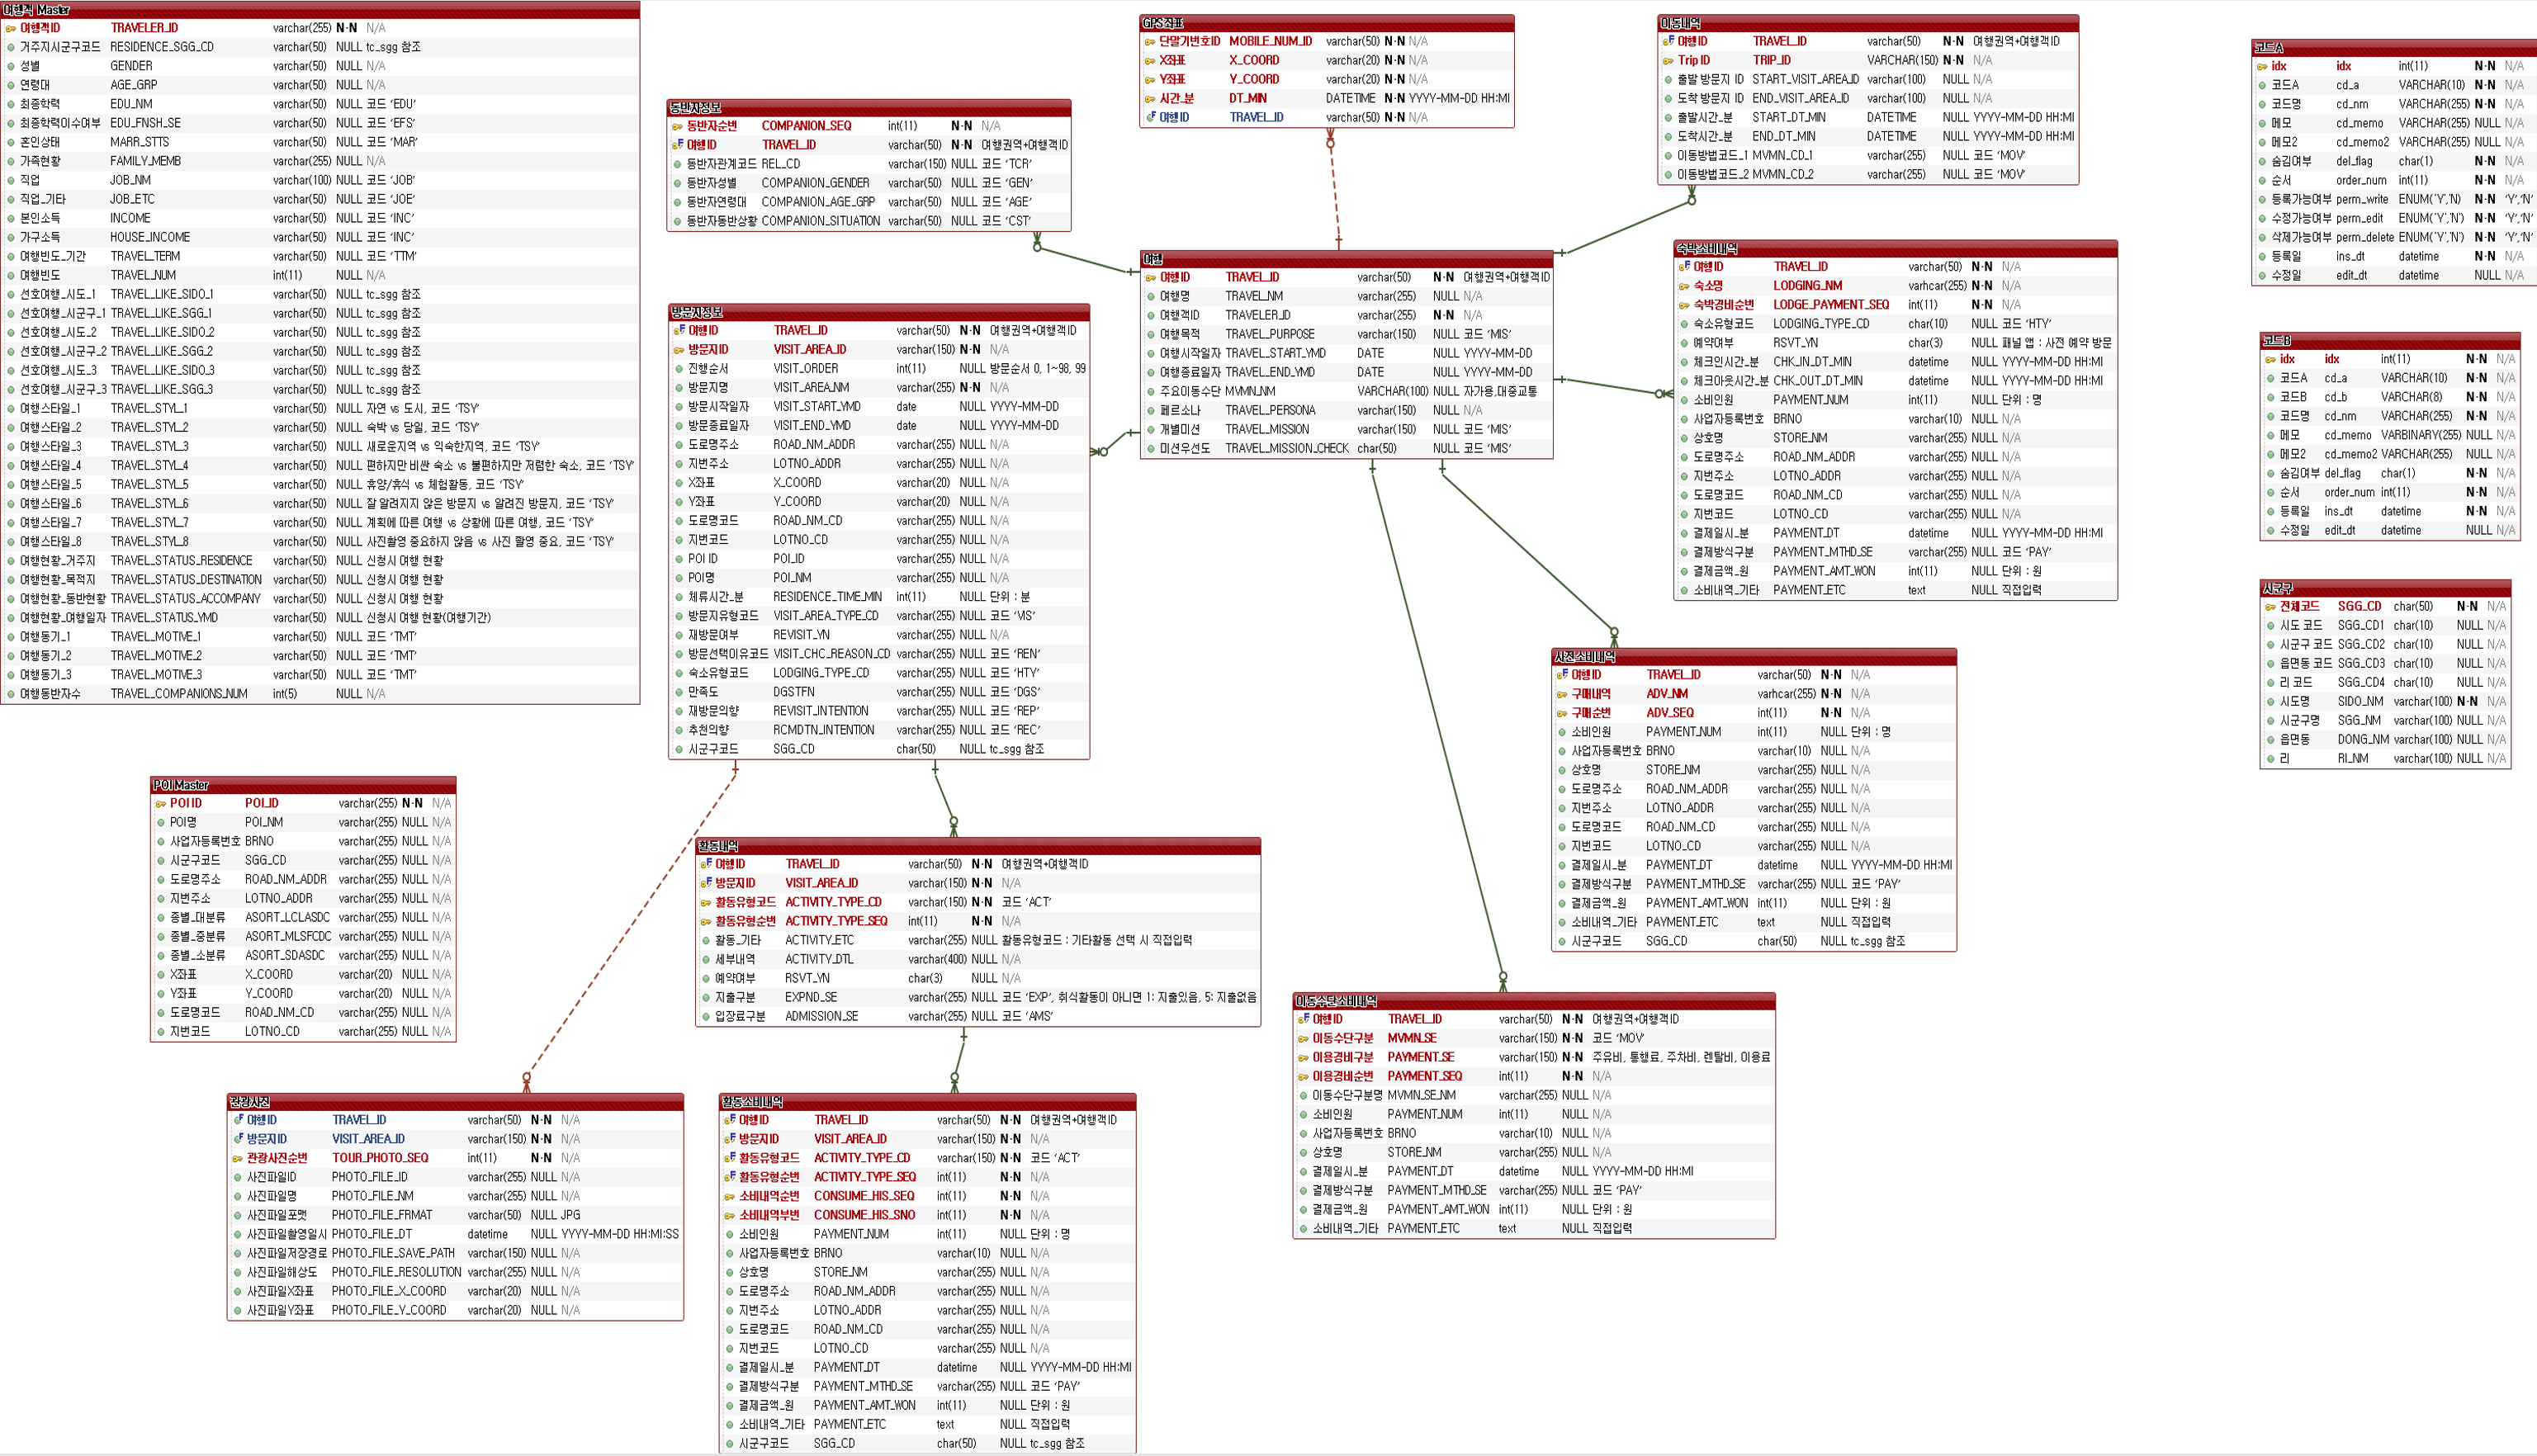


주요 연결 키:
  • TRAVELER_ID: 여행객 고유 식별자
  • TRAVEL_ID: 여행 고유 식별자

데이터 관계:
  • 여행객 ↔ 여행: 1:1 관계 (각 여행객당 1개 여행)
  • 여행 ↔ 소비내역: 1:N 관계 (각 여행당 여러 소비)

분석 전략:
  1. 여행객 정보 + 여행 정보 병합 (1:1 - 안전)
  2. 4개 소비내역 테이블을 TRAVEL_ID로 집계
  3. 총 소비금액 계산 후 1인당 소비금액 도출


In [15]:
# ERD 이미지 표시
from IPython.display import Image, display

print("="*80)
print("                   데이터베이스 ERD 구조")
print("="*80)

display(Image(filename=r'lableddata\erd.png'))

print("\n주요 연결 키:")
print("  • TRAVELER_ID: 여행객 고유 식별자")
print("  • TRAVEL_ID: 여행 고유 식별자")
print("\n데이터 관계:")
print("  • 여행객 ↔ 여행: 1:1 관계 (각 여행객당 1개 여행)")
print("  • 여행 ↔ 소비내역: 1:N 관계 (각 여행당 여러 소비)")
print("\n분석 전략:")
print("  1. 여행객 정보 + 여행 정보 병합 (1:1 - 안전)")
print("  2. 4개 소비내역 테이블을 TRAVEL_ID로 집계")
print("  3. 총 소비금액 계산 후 1인당 소비금액 도출")

### 샘플 데이터 확인

In [16]:
print("=" * 80)
print("[1] 여행객 정보 샘플")
print("=" * 80)
display(df_traveler.head(3))

print("\n" + "=" * 80)
print("[2] 여행 정보 샘플")
print("=" * 80)
display(df_travel.head(3))

print("\n" + "=" * 80)
print("[3] 활동 소비내역 샘플")
print("=" * 80)
display(df_activity.head(3))

[1] 여행객 정보 샘플


,TRAVELER_ID,RESIDENCE_SGG_CD,GENDER,AGE_GRP,EDU_NM,EDU_FNSH_SE,MARR_STTS,FAMILY_MEMB,JOB_NM,JOB_ETC,...,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_STATUS_YMD,TRAVEL_MOTIVE_1,TRAVEL_MOTIVE_2,TRAVEL_MOTIVE_3,TRAVEL_COMPANIONS_NUM
0,e004720,41,여,60,4,1.0,3,3,11,NaN,...,5,5,경기도,서울,2인 가족 여행,2023-07-16~2023-07-16,2,6.0,NaN,1
1,e000914,30,여,20,6,1.0,1,1,3,NaN,...,4,1,대전광역시,서울,나홀로 여행,2023-06-03~2023-06-03,1,7.0,10.0,0
2,e003564,41,여,30,7,1.0,2,4,2,NaN,...,1,7,경기도,경기,자녀 동반 여행,2023-06-24~2023-06-24,8,3.0,7.0,3



[2] 여행 정보 샘플


,TRAVEL_ID,TRAVEL_NM,TRAVELER_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_PERSONA,TRAVEL_MISSION,TRAVEL_MISSION_CHECK
0,e_e000004,E03,e000004,3,2023-04-30,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/40세 이상/자녀동반/일반미션,3,3;4;11
1,e_e000006,E03,e000006,21,2023-04-30,2023-05-02,NaN,경기 방문/거주지 구분 없음/39세 이하/특별미션,21,21;10;27
2,e_e000009,E03,e000009,2;4,2023-04-29,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/39세 이하/커플/일반미션,2;4,22;1;7



[3] 활동 소비내역 샘플


,TRAVEL_ID,VISIT_AREA_ID,ACTIVITY_TYPE_CD,ACTIVITY_TYPE_SEQ,CONSUME_HIS_SEQ,CONSUME_HIS_SNO,PAYMENT_NUM,BRNO,STORE_NM,ROAD_NM_ADDR,LOTNO_ADDR,ROAD_NM_CD,LOTNO_CD,PAYMENT_DT,PAYMENT_MTHD_SE,PAYMENT_AMT_WON,PAYMENT_ETC,SGG_CD
0,e_e002053,2306030007,2,0,0,1,1,4.013801e+09,CU,경기 시흥시 비둘기공원7길 65,경기 시흥시 대야동 550-4,4397301.0,4.139010e+09,2023-06-03 23:01,1,6500,새우깡블랙;뉴리뉴멀티,NaN
1,e_e001001,2306090003,1,0,0,1,2,1.338122e+09,가평(춘천)휴게소,경기 가평군 설악면 미사리로540번길 51,NaN,4448077.0,4.182031e+09,2023-06-09 20:16,1,5500,통감자,NaN
2,e_e009156,2308260006,1,0,0,1,2,2.204101e+09,개항백화,인천 중구 개항로 104,인천 중구 경동 114,3149001.0,2.811013e+09,2023-08-26 15:42,1,22000,ICED 아메리카노;개항로 맥주,NaN


## 3. 데이터 전처리 및 통합

In [17]:
# 3.1 소비내역 집계
# 여행 ID를 기반으로, 각 분야(활동,사전,숙박,이동) 의 소비 합계를 계산함
print("소비내역 집계 중...")

# 각 소비 카테고리별 합계 계산
activity_sum = df_activity.groupby('TRAVEL_ID')['PAYMENT_AMT_WON'].sum().reset_index()
activity_sum.columns = ['TRAVEL_ID', 'activity_spending']

advance_sum = df_advance.groupby('TRAVEL_ID')['PAYMENT_AMT_WON'].sum().reset_index()
advance_sum.columns = ['TRAVEL_ID', 'advance_spending']

lodge_sum = df_lodge.groupby('TRAVEL_ID')['PAYMENT_AMT_WON'].sum().reset_index()
lodge_sum.columns = ['TRAVEL_ID', 'lodge_spending']

movement_sum = df_movement.groupby('TRAVEL_ID')['PAYMENT_AMT_WON'].sum().reset_index()
movement_sum.columns = ['TRAVEL_ID', 'movement_spending']

print("✓ 소비내역 집계 완료")

소비내역 집계 중...
✓ 소비내역 집계 완료


데이터 병합 및 결측치 분석

데이터 병합 중...
✓ 병합 완료: 2560건

소비 컬럼별 결측치 현황:
                   결측치 개수  결측치 비율(%)
activity_spending      29       1.13
advance_spending     2019      78.87
lodge_spending       1894      73.98
movement_spending     201       7.85


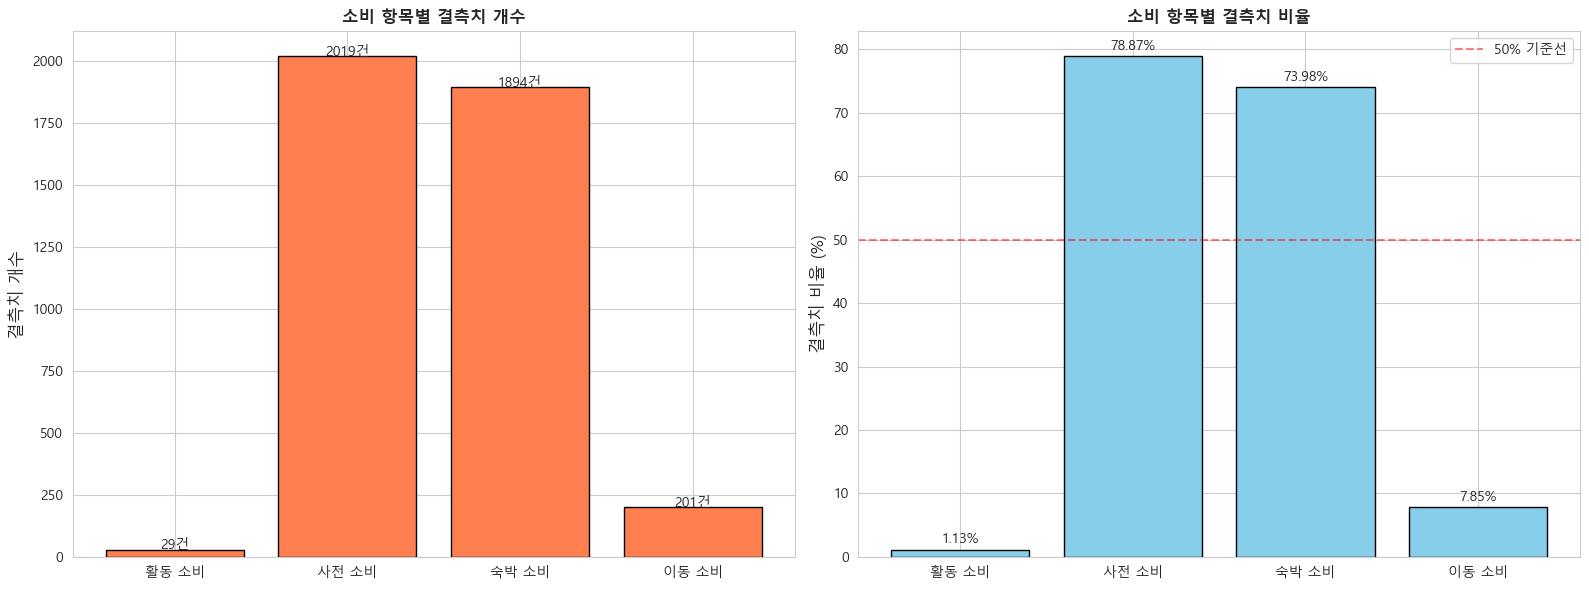


결측치 해석:
  • 결측치는 해당 소비 항목이 없는 여행을 의미
  • 예: 당일치기 여행은 숙박 소비가 없을 수 있음
  • 처리 방법: 결측치를 0으로 대체 (소비 없음 = 0원)

결측치가 있는 여행 예시:


,TRAVEL_ID,TRAVELER_ID,activity_spending,advance_spending,lodge_spending,movement_spending
0,e_e004720,e004720,39420.0,NaN,NaN,7800.0
1,e_e000914,e000914,44600.0,NaN,NaN,47150.0
2,e_e003564,e003564,69800.0,NaN,NaN,25000.0


In [18]:
# 3.2 데이터 병합 및 결측치 확인
print("="*80)
print("데이터 병합 및 결측치 분석")
print("="*80)

# 병합
print("\n데이터 병합 중...")
df = df_traveler.merge(df_travel, on='TRAVELER_ID', how='left')
df = df.merge(activity_sum, on='TRAVEL_ID', how='left')
df = df.merge(advance_sum, on='TRAVEL_ID', how='left')
df = df.merge(lodge_sum, on='TRAVEL_ID', how='left')
df = df.merge(movement_sum, on='TRAVEL_ID', how='left')

print(f"✓ 병합 완료: {len(df)}건\n")

# 소비 관련 컬럼
spending_cols = ['activity_spending', 'advance_spending', 'lodge_spending', 'movement_spending']

# 결측치 개수 및 비율
missing_count = df[spending_cols].isnull().sum()
missing_pct = (missing_count / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    '결측치 개수': missing_count,
    '결측치 비율(%)': missing_pct
})

print("소비 컬럼별 결측치 현황:")
print(missing_df)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 결측치 개수
axes[0].bar(range(len(missing_count)), missing_count.values, color='coral', edgecolor='black')
axes[0].set_xticks(range(len(missing_count)))
axes[0].set_xticklabels(['활동 소비', '사전 소비', '숙박 소비', '이동 소비'])
axes[0].set_ylabel('결측치 개수', fontsize=12)
axes[0].set_title('소비 항목별 결측치 개수', fontsize=12, fontweight='bold')
for i, v in enumerate(missing_count.values):
    if v > 0:
        axes[0].text(i, v + 2, f'{v}건', ha='center', fontsize=10)

# 결측치 비율
axes[1].bar(range(len(missing_pct)), missing_pct.values, color='skyblue', edgecolor='black')
axes[1].set_xticks(range(len(missing_pct)))
axes[1].set_xticklabels(['활동 소비', '사전 소비', '숙박 소비', '이동 소비'])
axes[1].set_ylabel('결측치 비율 (%)', fontsize=12)
axes[1].set_title('소비 항목별 결측치 비율', fontsize=12, fontweight='bold')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% 기준선')
axes[1].legend()
for i, v in enumerate(missing_pct.values):
    if v > 0:
        axes[1].text(i, v + 1, f'{v}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n결측치 해석:")
print("  • 결측치는 해당 소비 항목이 없는 여행을 의미")
print("  • 예: 당일치기 여행은 숙박 소비가 없을 수 있음")
print("  • 처리 방법: 결측치를 0으로 대체 (소비 없음 = 0원)")

# 결측치 샘플
if missing_count.sum() > 0:
    print("\n결측치가 있는 여행 예시:")
    sample = df[df[spending_cols].isnull().any(axis=1)][['TRAVEL_ID', 'TRAVELER_ID'] + spending_cols].head(3)
    display(sample)

In [19]:
# 3.3 결측치 처리
print("="*80)
print("결측치 처리")
print("="*80)

# 결측치를 0으로 채우기 (소비 없는 경우 = 0원)
df[spending_cols] = df[spending_cols].fillna(0)

print(f"✓ 결측치 처리 완료")
print(f"✓ 처리된 결측치: {missing_count.sum()}건")
print(f"\n최종 데이터:")
print(f"  - 총 {len(df)}건")
print(f"  - 컬럼 수: {len(df.columns)}개")
print(f"  - 결측치: {df[spending_cols].isnull().sum().sum()}건 (모두 처리됨)")

결측치 처리
✓ 결측치 처리 완료
✓ 처리된 결측치: 4143건

최종 데이터:
  - 총 2560건
  - 컬럼 수: 49개
  - 결측치: 0건 (모두 처리됨)


In [20]:
# 3.4 타겟 변수 생성: 1인당 소비금액
print("타겟 변수 생성 중...")

# 총 소비금액
df['total_spending'] = df[spending_cols].sum(axis=1)

# 여행 인원 = 동반자 수 + 본인(1)
df['num_people'] = df['TRAVEL_COMPANIONS_NUM'] + 1

# 1인당 소비금액 = 총 소비 / 인원
df['per_person_spending'] = df['total_spending'] / df['num_people']

print("\n✓ 타겟 변수 기본 통계:")
stats = df['per_person_spending'].describe()
for key, value in stats.items():
    print(f"  {key:8s}: {value:>12,.0f}")

타겟 변수 생성 중...

✓ 타겟 변수 기본 통계:
  count   :        2,560
  mean    :      113,185
  std     :      207,645
  min     :            0
  25%     :       37,919
  50%     :       68,450
  75%     :      133,169
  max     :    7,722,425


In [21]:
# 3.5 파생 변수 생성
print("="*80)
print("파생 변수 생성")
print("="*80)
# 날짜 변환
df['TRAVEL_START_YMD'] = pd.to_datetime(df['TRAVEL_START_YMD'])
df['TRAVEL_END_YMD'] = pd.to_datetime(df['TRAVEL_END_YMD'])
# 체류 기간 (일)
df['stay_days'] = (df['TRAVEL_END_YMD'] - df['TRAVEL_START_YMD']).dt.days
# 여행 월
df['month'] = df['TRAVEL_START_YMD'].dt.month
# 계절 매핑
season_map = {
    1: '겨울', 2: '겨울', 3: '봄', 4: '봄', 5: '봄', 6: '여름',
    7: '여름', 8: '여름', 9: '가을', 10: '가을', 11: '가을', 12: '겨울'
}
df['season'] = df['month'].map(season_map)
# 목적지 매핑
destination_map = {
    'E01': '강원', 'E02': '경기', 'E03': '서울', 'E04': '인천',
    'E05': '대전', 'E06': '충남', 'E07': '충북', 'E08': '세종'
}
df['destination'] = df['TRAVEL_NM'].map(destination_map)
# 연령대/성별 인코딩
df['age_numeric'] = df['AGE_GRP']
df['gender_encoded'] = df['GENDER'].map({'남': 0, '여': 1})
print("✓ 파생 변수 생성 완료")
print(f"  - stay_days: {df['stay_days'].min()}~{df['stay_days'].max()}일")
print(f"  - 계절: {df['season'].value_counts().to_dict()}")
print(f"  - 목적지: {df['destination'].value_counts().to_dict()}")


파생 변수 생성
✓ 파생 변수 생성 완료
  - stay_days: 1~5일
  - 계절: {'여름': 2119, '봄': 345, '가을': 96}
  - 목적지: {'서울': 1574, '강원': 791, '경기': 195}



## 4. 탐색적 데이터 분석 (EDA)

### 4.1 Group A: 방문객 특성

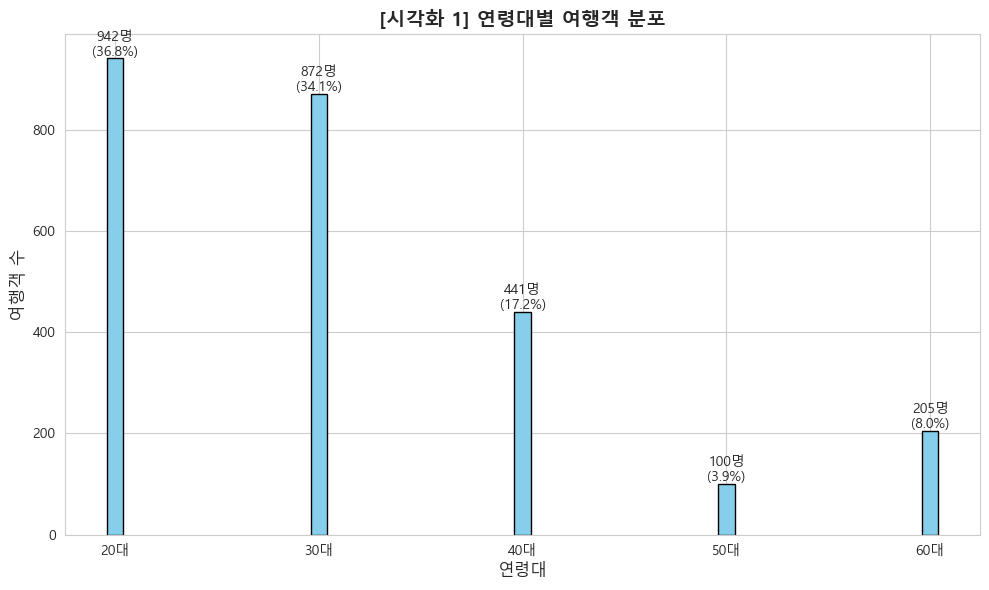


인사이트: 20-30대가 전체의 약 70%를 차지


In [22]:
# 시각화 1: 연령대 분포
plt.figure(figsize=(10, 6))
age_counts = df['AGE_GRP'].value_counts().sort_index()
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('연령대', fontsize=12)
plt.ylabel('여행객 수', fontsize=12)
plt.title('[시각화 1] 연령대별 여행객 분포', fontsize=14, fontweight='bold')
plt.xticks(age_counts.index, [f'{age}대' for age in age_counts.index])

# 비율 추가
for i, v in enumerate(age_counts.values):
    plt.text(age_counts.index[i], v + 5, f'{v}명\n({v/len(df)*100:.1f}%)', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n인사이트: 20-30대가 전체의 약 70%를 차지")

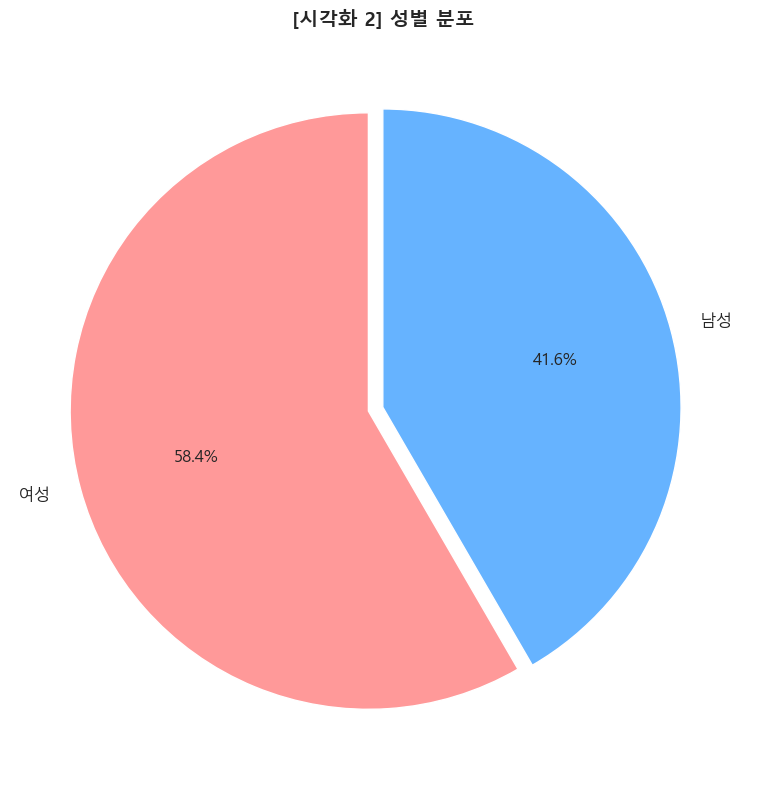


인사이트: 여성 여행객이 58.4%로 더 많음


In [23]:
# 시각화 2: 성별 분포
plt.figure(figsize=(8, 8))
gender_counts = df['GENDER'].value_counts()
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0)

plt.pie(gender_counts.values, labels=['여성', '남성'], autopct='%1.1f%%', 
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
plt.title('[시각화 2] 성별 분포', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n인사이트: 여성 여행객이 {gender_counts['여']/len(df)*100:.1f}%로 더 많음")


인사이트:
  - 혼자 여행: 565건 (22.1%)
  - 2인 여행: 1212건 (47.3%)


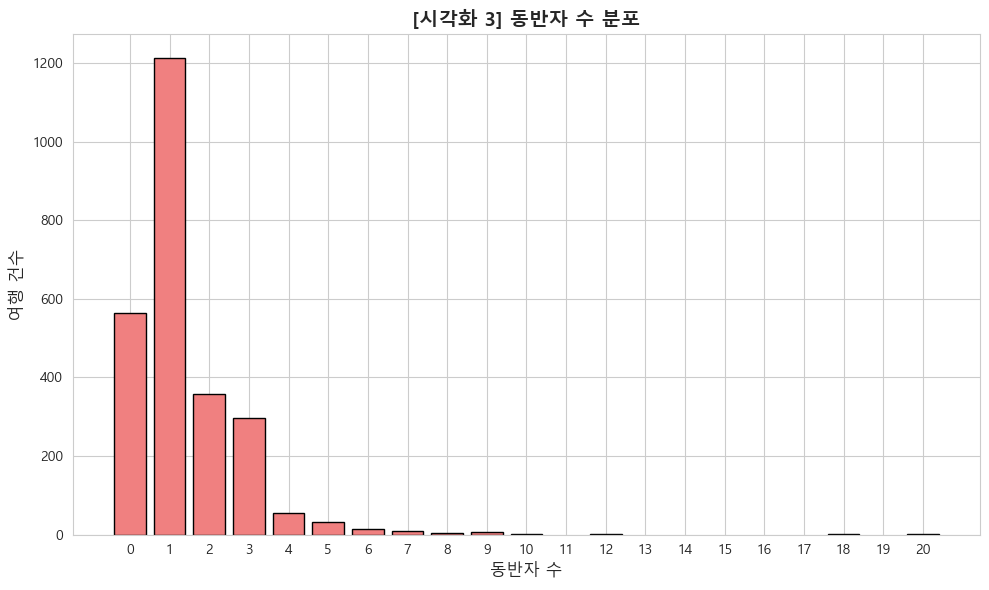

In [24]:
# 시각화 3: 동반자 수 분포
plt.figure(figsize=(10, 6))
companion_counts = df['TRAVEL_COMPANIONS_NUM'].value_counts().sort_index()
plt.bar(companion_counts.index, companion_counts.values, color='lightcoral', edgecolor='black')
plt.xlabel('동반자 수', fontsize=12)
plt.ylabel('여행 건수', fontsize=12)
plt.title('[시각화 3] 동반자 수 분포', fontsize=14, fontweight='bold')
plt.xticks(range(0, companion_counts.index.max() + 1))

# 주요 카테고리 강조
solo_count = companion_counts.get(0, 0)
couple_count = companion_counts.get(1, 0)
print(f"\n인사이트:")
print(f"  - 혼자 여행: {solo_count}건 ({solo_count/len(df)*100:.1f}%)")
print(f"  - 2인 여행: {couple_count}건 ({couple_count/len(df)*100:.1f}%)")

plt.tight_layout()
plt.show()

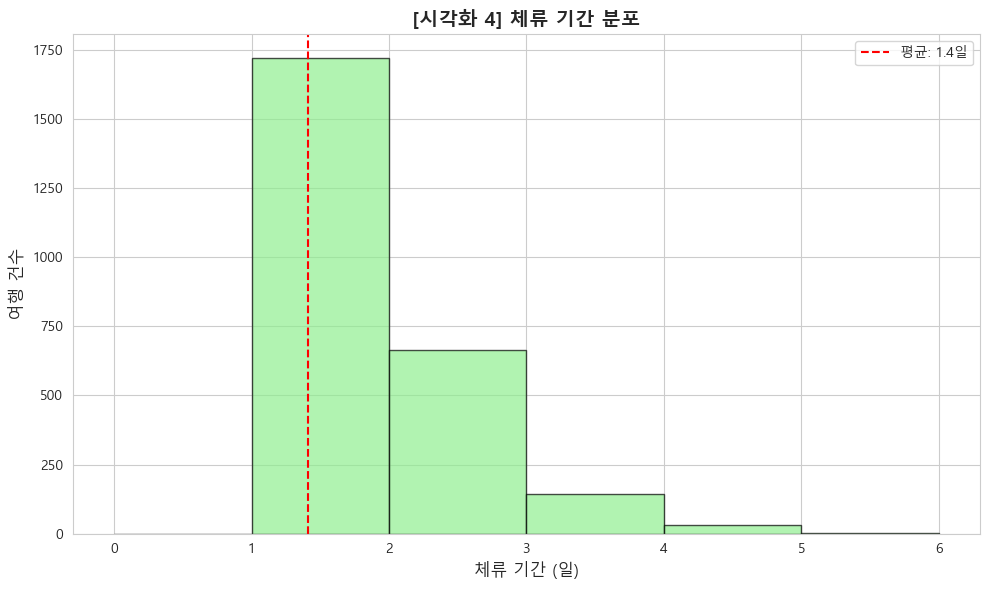


인사이트:
  - 평균 체류: 1.4일
  - 당일치기: 0건
  - 1박2일: 1719건
  - 2박 이상: 841건


In [25]:
# 시각화 4: 체류 기간 분포
plt.figure(figsize=(10, 6))
plt.hist(df['stay_days'], bins=range(0, int(df['stay_days'].max()) + 2), 
         color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('체류 기간 (일)', fontsize=12)
plt.ylabel('여행 건수', fontsize=12)
plt.title('[시각화 4] 체류 기간 분포', fontsize=14, fontweight='bold')
plt.axvline(df['stay_days'].mean(), color='red', linestyle='--', 
            label=f'평균: {df["stay_days"].mean():.1f}일')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n인사이트:")
print(f"  - 평균 체류: {df['stay_days'].mean():.1f}일")
print(f"  - 당일치기: {(df['stay_days'] == 0).sum()}건")
print(f"  - 1박2일: {(df['stay_days'] == 1).sum()}건")
print(f"  - 2박 이상: {(df['stay_days'] >= 2).sum()}건")

### 4.2 Group B: 지역 및 시간 정보

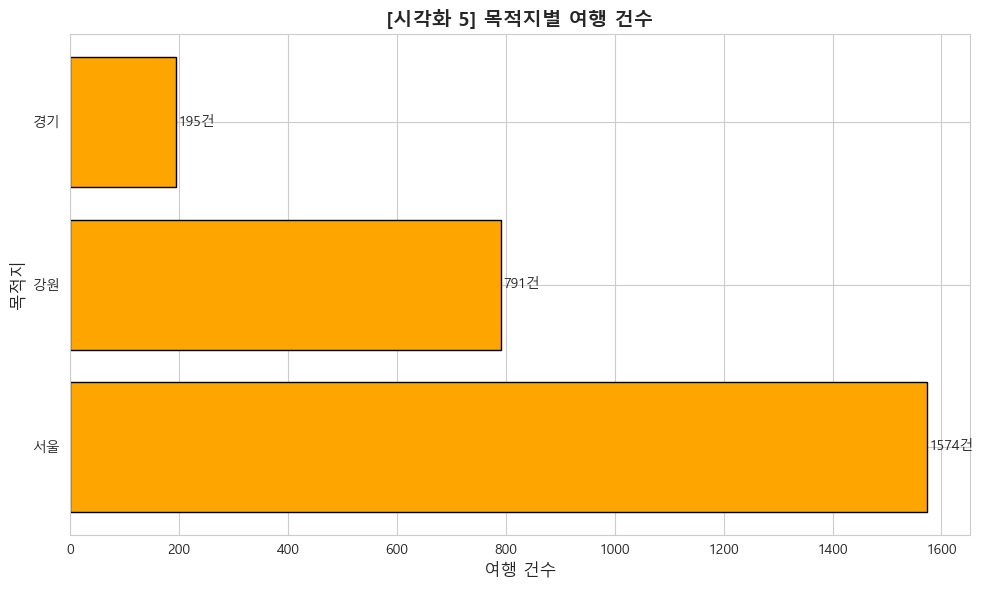


인사이트: 서울이(가) 가장 인기 있는 목적지


In [28]:
# 시각화 5: 목적지별 분포
plt.figure(figsize=(10, 6))
dest_counts = df['destination'].value_counts()
plt.barh(dest_counts.index, dest_counts.values, color='orange', edgecolor='black')
plt.xlabel('여행 건수', fontsize=12)
plt.ylabel('목적지', fontsize=12)
plt.title('[시각화 5] 목적지별 여행 건수', fontsize=14, fontweight='bold')

# 값 표시
for i, v in enumerate(dest_counts.values):
    plt.text(v + 5, i, f'{v}건', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n인사이트: {dest_counts.index[0]}이(가) 가장 인기 있는 목적지")

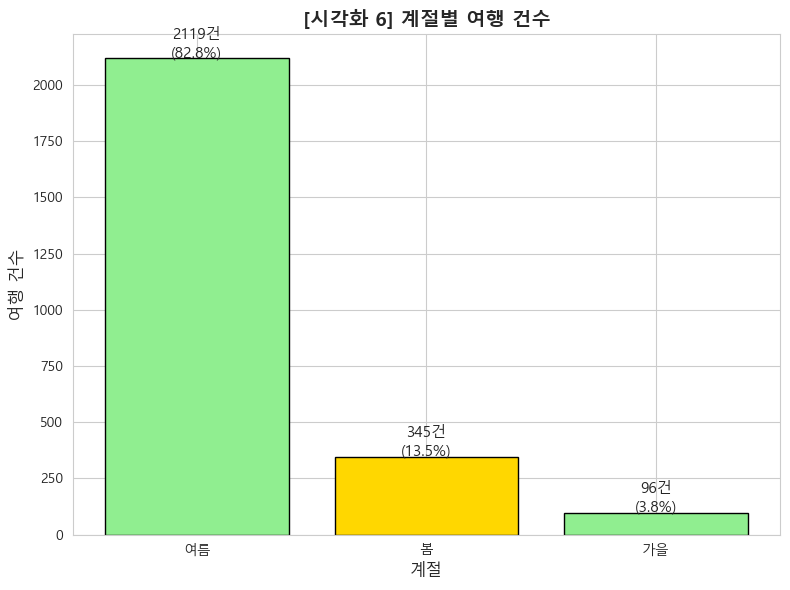


인사이트: 데이터는 여름-가을 시즌 (8-11월)만 포함


In [27]:
# 시각화 6: 계절별 분포
plt.figure(figsize=(8, 6))
season_counts = df['season'].value_counts()
plt.bar(season_counts.index, season_counts.values, color=['#90EE90', '#FFD700'], edgecolor='black')
plt.xlabel('계절', fontsize=12)
plt.ylabel('여행 건수', fontsize=12)
plt.title('[시각화 6] 계절별 여행 건수', fontsize=14, fontweight='bold')

for i, v in enumerate(season_counts.values):
    plt.text(i, v + 5, f'{v}건\n({v/len(df)*100:.1f}%)', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print("\n인사이트: 데이터는 여름-가을 시즌 (8-11월)만 포함")

### 4.3 타겟 변수: 1인당 소비금액

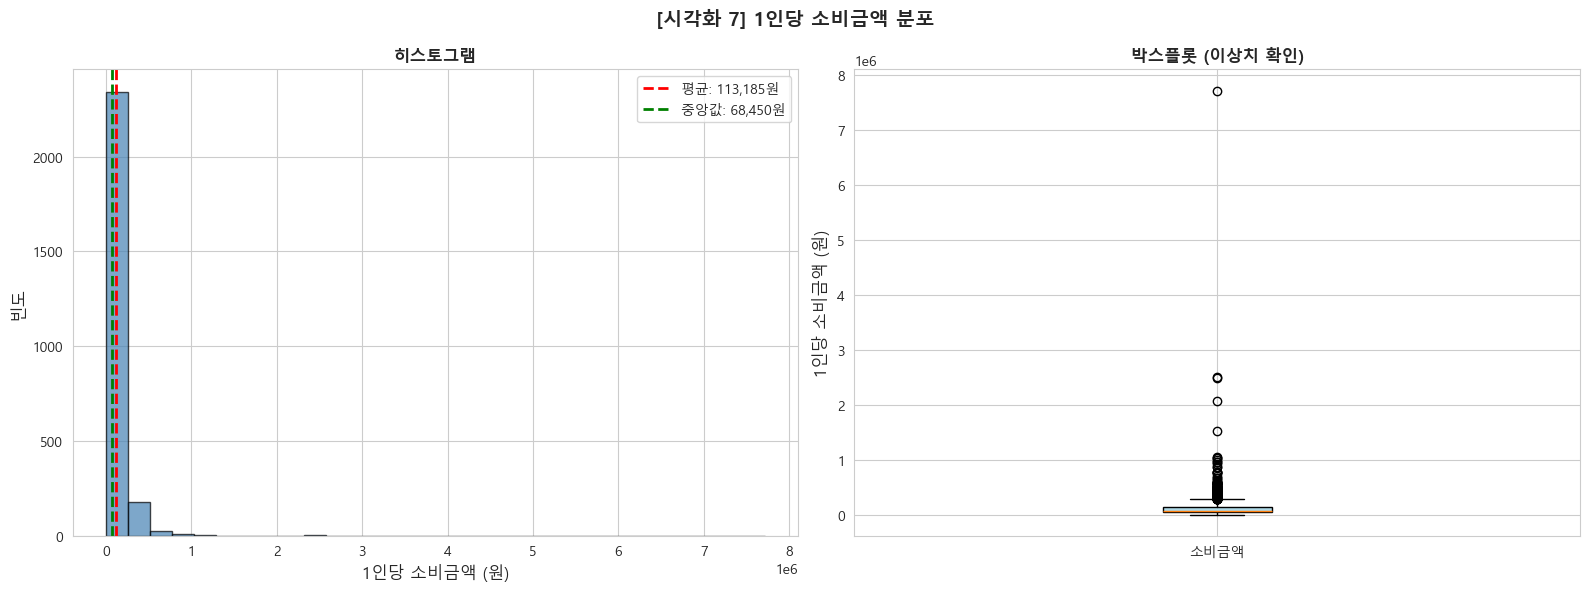


기술 통계:
  - 평균: 113,185원
  - 중앙값: 68,450원
  - 최소: 0원
  - 최대: 7,722,425원
  - 표준편차: 207,645원


In [29]:
# 시각화 7: 1인당 소비금액 분포
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 히스토그램
axes[0].hist(df['per_person_spending'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['per_person_spending'].mean(), color='red', linestyle='--', 
                label=f'평균: {df["per_person_spending"].mean():,.0f}원', linewidth=2)
axes[0].axvline(df['per_person_spending'].median(), color='green', linestyle='--', 
                label=f'중앙값: {df["per_person_spending"].median():,.0f}원', linewidth=2)
axes[0].set_xlabel('1인당 소비금액 (원)', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('히스토그램', fontsize=12, fontweight='bold')
axes[0].legend()

# 박스플롯
axes[1].boxplot(df['per_person_spending'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_ylabel('1인당 소비금액 (원)', fontsize=12)
axes[1].set_title('박스플롯 (이상치 확인)', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['소비금액'])

fig.suptitle('[시각화 7] 1인당 소비금액 분포', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n기술 통계:")
print(f"  - 평균: {df['per_person_spending'].mean():,.0f}원")
print(f"  - 중앙값: {df['per_person_spending'].median():,.0f}원")
print(f"  - 최소: {df['per_person_spending'].min():,.0f}원")
print(f"  - 최대: {df['per_person_spending'].max():,.0f}원")
print(f"  - 표준편차: {df['per_person_spending'].std():,.0f}원")

### 4.4 이변량 분석: 소비금액과 각 변수의 관계

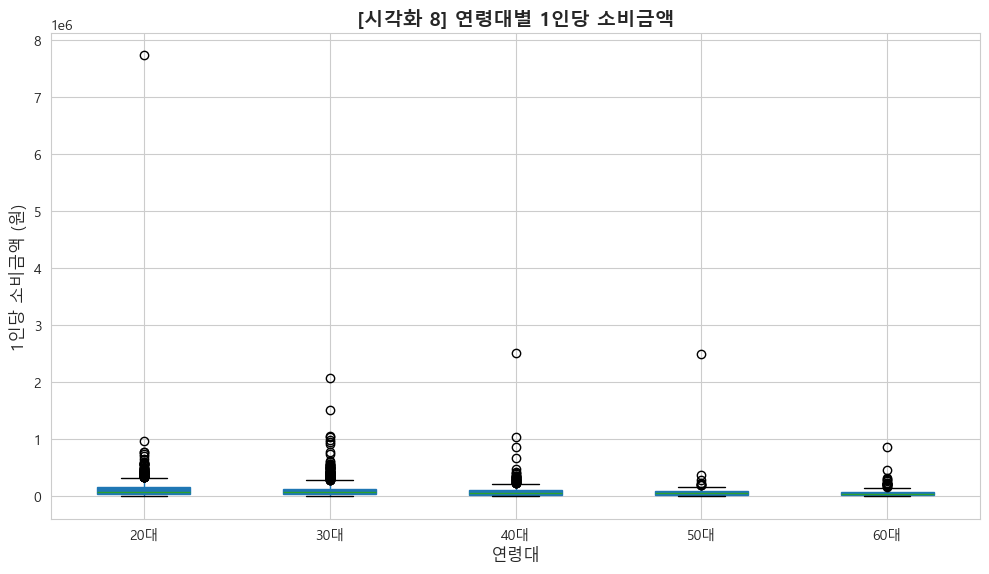


연령대별 평균 소비금액:
  20대: 129,919원
  30대: 116,803원
  40대: 92,970원
  50대: 96,062원
  60대: 72,739원


In [30]:
# 시각화 8: 연령대별 소비금액
plt.figure(figsize=(10, 6))
df.boxplot(column='per_person_spending', by='AGE_GRP', patch_artist=True, ax=plt.gca())
plt.xlabel('연령대', fontsize=12)
plt.ylabel('1인당 소비금액 (원)', fontsize=12)
plt.title('[시각화 8] 연령대별 1인당 소비금액', fontsize=14, fontweight='bold')
plt.suptitle('')  # 기본 제목 제거
plt.xticks(range(1, len(df['AGE_GRP'].unique()) + 1), 
           [f'{age}대' for age in sorted(df['AGE_GRP'].unique())])
plt.tight_layout()
plt.show()

# 연령대별 평균
age_spending = df.groupby('AGE_GRP')['per_person_spending'].mean().sort_index()
print("\n연령대별 평균 소비금액:")
for age, spending in age_spending.items():
    print(f"  {age}대: {spending:,.0f}원")

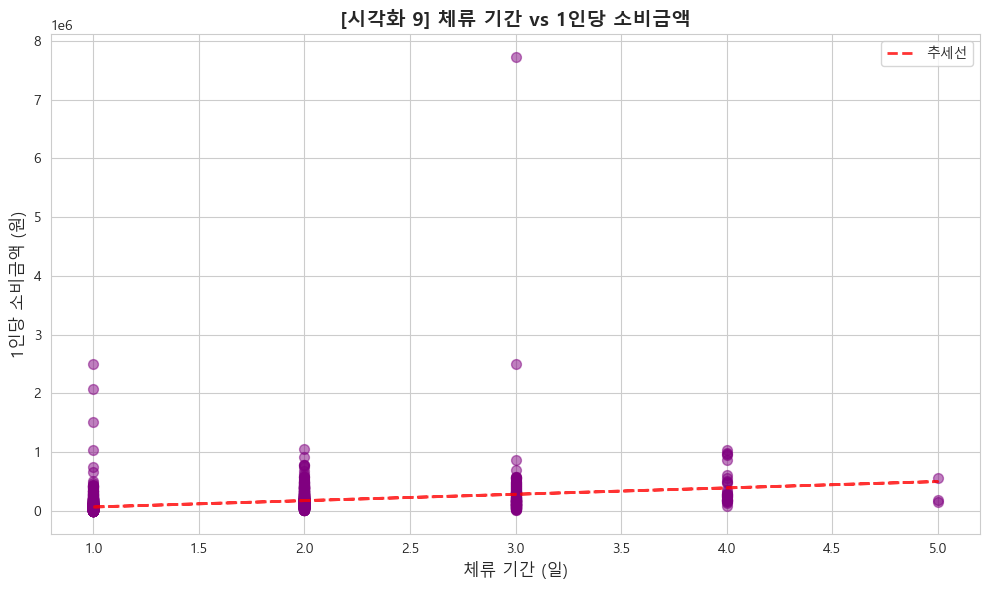


상관계수: 0.346
인사이트: 체류 기간이 길수록 1인당 소비금액이 증가하는 경향


In [31]:
# 시각화 9: 체류기간 vs 소비금액 (산점도)
plt.figure(figsize=(10, 6))
plt.scatter(df['stay_days'], df['per_person_spending'], alpha=0.5, c='purple', s=50)
plt.xlabel('체류 기간 (일)', fontsize=12)
plt.ylabel('1인당 소비금액 (원)', fontsize=12)
plt.title('[시각화 9] 체류 기간 vs 1인당 소비금액', fontsize=14, fontweight='bold')

# 추세선
z = np.polyfit(df['stay_days'], df['per_person_spending'], 1)
p = np.poly1d(z)
plt.plot(df['stay_days'], p(df['stay_days']), "r--", alpha=0.8, linewidth=2, label='추세선')
plt.legend()

plt.tight_layout()
plt.show()

# 상관계수
corr = df['stay_days'].corr(df['per_person_spending'])
print(f"\n상관계수: {corr:.3f}")
if corr > 0.3:
    print("인사이트: 체류 기간이 길수록 1인당 소비금액이 증가하는 경향")
elif corr < -0.3:
    print("인사이트: 체류 기간이 길수록 1인당 소비금액이 감소하는 경향")
else:
    print("인사이트: 체류 기간과 소비금액 간 뚜렷한 선형 관계 없음")

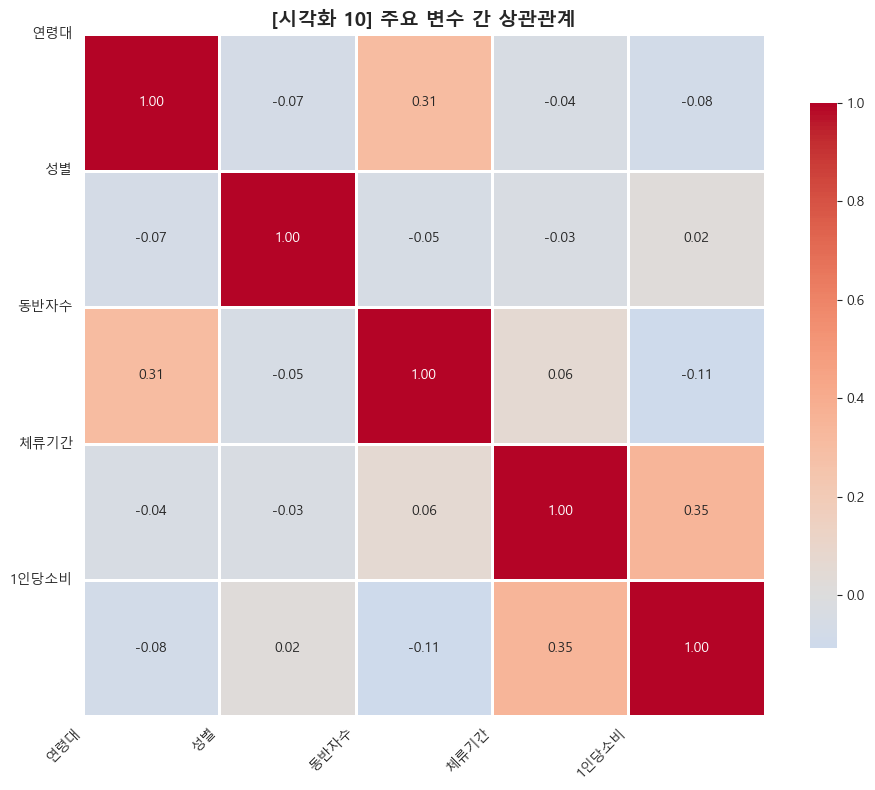


1인당 소비금액과의 상관계수:
  체류기간: 0.346
  성별: 0.020
  연령대: -0.084
  동반자수: -0.107


In [32]:
# 시각화 10: 상관관계 히트맵
plt.figure(figsize=(10, 8))

# 주요 수치형 변수 선택
numeric_features = ['age_numeric', 'gender_encoded', 'TRAVEL_COMPANIONS_NUM', 
                    'stay_days', 'per_person_spending']
corr_matrix = df[numeric_features].corr()

# 히트맵
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

# 레이블 한글화
labels = ['연령대', '성별', '동반자수', '체류기간', '1인당소비']
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels, rotation=0)

plt.title('[시각화 10] 주요 변수 간 상관관계', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n1인당 소비금액과의 상관계수:")
target_corr = corr_matrix['per_person_spending'].sort_values(ascending=False)
for feature, corr_val in target_corr.items():
    if feature != 'per_person_spending':
        print(f"  {labels[numeric_features.index(feature)]}: {corr_val:.3f}")

## 5. 예측 모델 개발

### 5.1 데이터 준비

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 결측치 제거
df_model = df.dropna(subset=['per_person_spending', 'AGE_GRP', 'GENDER',
                              'TRAVEL_COMPANIONS_NUM', 'stay_days',
                              'destination', 'season']).copy()

# 목적지와 계절 원-핫 인코딩
destination_dummies = pd.get_dummies(df_model['destination'], prefix='dest')
season_dummies = pd.get_dummies(df_model['season'], prefix='season')

# 기존 피쳐와 인코딩된 피쳐 결합
df_model = pd.concat([df_model, destination_dummies, season_dummies], axis=1)

# 피쳐 선택 (원-핫 인코딩된 컬럼 포함)
feature_cols = ['age_numeric', 'gender_encoded', 'TRAVEL_COMPANIONS_NUM', 'stay_days']
feature_cols += list(destination_dummies.columns)
feature_cols += list(season_dummies.columns)

X = df_model[feature_cols]
y = df_model['per_person_spending']

# Train/Test 분할 (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"학습 데이터: {len(X_train)}건")
print(f"테스트 데이터: {len(X_test)}건")
print(f"\n사용 피쳐 ({len(feature_cols)}개):")
print(f"  - 기본: age_numeric, gender_encoded, TRAVEL_COMPANIONS_NUM, stay_days")
print(f"  - 목적지: {list(destination_dummies.columns)}")
print(f"  - 계절: {list(season_dummies.columns)}")

### 5.2 모델 학습

#### 옵션 A: 선형 회귀 (Linear Regression)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 예측
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("="*60)
print("선형 회귀 모델 성능")
print("="*60)
print(f"[학습 데이터]")
print(f"  RMSE: {train_rmse:,.0f}원")
print(f"  R²: {train_r2:.4f}")
print(f"\n[테스트 데이터]")
print(f"  RMSE: {test_rmse:,.0f}원")
print(f"  MAE: {test_mae:,.0f}원")
print(f"  R²: {test_r2:.4f}")
print("="*60)

# 회귀 계수 해석
print("\n회귀 계수 (각 변수의 영향력):")
print(f"  절편: {lr_model.intercept_:,.0f}원\n")
print("[기본 피쳐]")
for i, name in enumerate(['연령대(10세 증가)', '성별(여성)', '동반자수(1명 증가)', '체류기간(1일 증가)']):
    print(f"  {name}: {lr_model.coef_[i]:+,.0f}원")

print("\n[목적지 피쳐]")
for i, col in enumerate(destination_dummies.columns, start=4):
    print(f"  {col}: {lr_model.coef_[i]:+,.0f}원")

print("\n[계절 피쳐]")
offset = 4 + len(destination_dummies.columns)
for i, col in enumerate(season_dummies.columns, start=offset):
    print(f"  {col}: {lr_model.coef_[i]:+,.0f}원")

#### 옵션 B: 결정 트리 (Decision Tree)

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# 모델 학습 (깊이 제한으로 과적합 방지)
dt_model = DecisionTreeRegressor(max_depth=5, min_samples_split=20, random_state=42)
dt_model.fit(X_train, y_train)

# 예측
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# 평가
train_rmse_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
test_rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
train_r2_dt = r2_score(y_train, y_train_pred_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)
test_mae_dt = mean_absolute_error(y_test, y_test_pred_dt)

print("="*60)
print("결정 트리 모델 성능")
print("="*60)
print(f"[학습 데이터]")
print(f"  RMSE: {train_rmse_dt:,.0f}원")
print(f"  R²: {train_r2_dt:.4f}")
print(f"\n[테스트 데이터]")
print(f"  RMSE: {test_rmse_dt:,.0f}원")
print(f"  MAE: {test_mae_dt:,.0f}원")
print(f"  R²: {test_r2_dt:.4f}")
print("="*60)

# 피쳐 중요도 (상위 10개만 표시)
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n피쳐 중요도 (상위 10개):")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

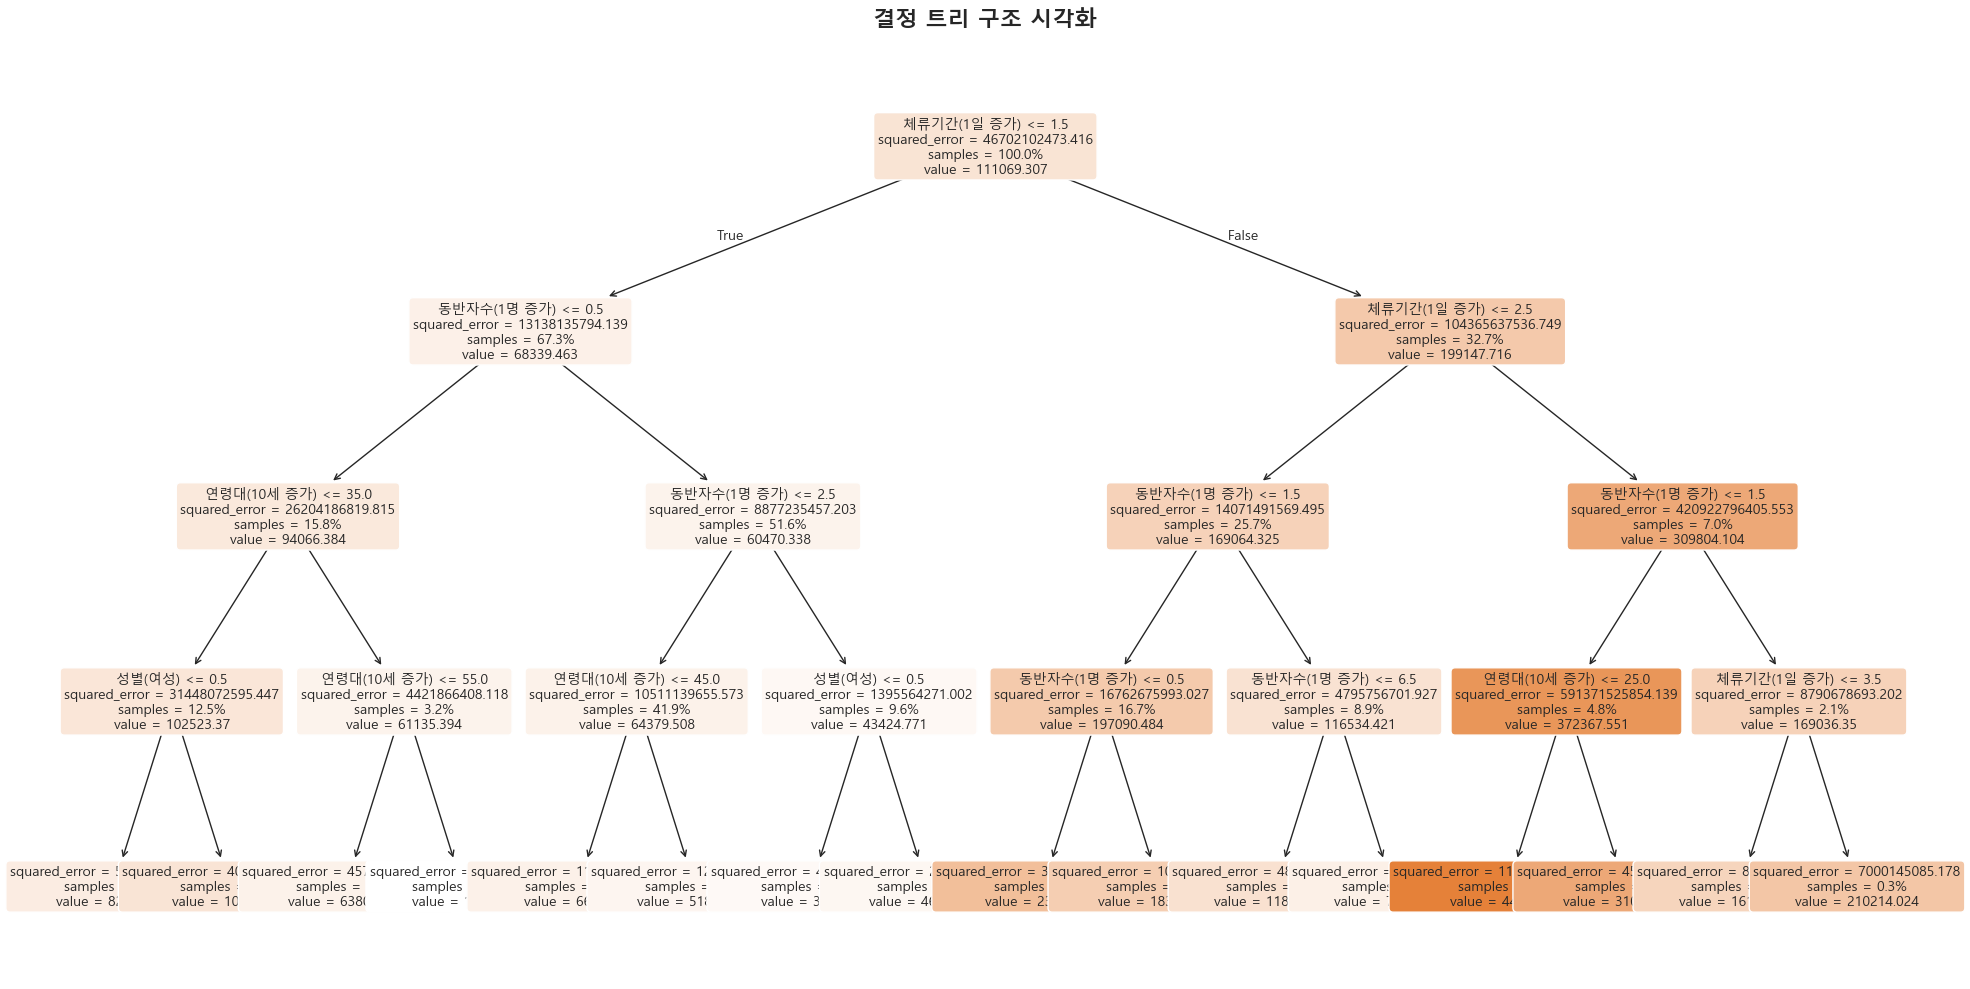


트리 해석 예시:
  - 루트 노드에서 가장 중요한 분할 기준 확인
  - 리프 노드의 값이 예측 소비금액
  - 색이 진할수록 더 높은 소비금액 구간


In [36]:
# 결정 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_names, filled=True, rounded=True, 
          fontsize=10, proportion=True)
plt.title('결정 트리 구조 시각화', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n트리 해석 예시:")
print("  - 루트 노드에서 가장 중요한 분할 기준 확인")
print("  - 리프 노드의 값이 예측 소비금액")
print("  - 색이 진할수록 더 높은 소비금액 구간")

### 5.3 모델 비교 및 선택


모델 성능 비교:
   모델   RMSE (Test)   MAE (Test)  R² (Test)  R² (Train)
선형 회귀 143995.589227 66479.091202   0.275019    0.115665
결정 트리 144018.726524 64978.456459   0.274786    0.137076


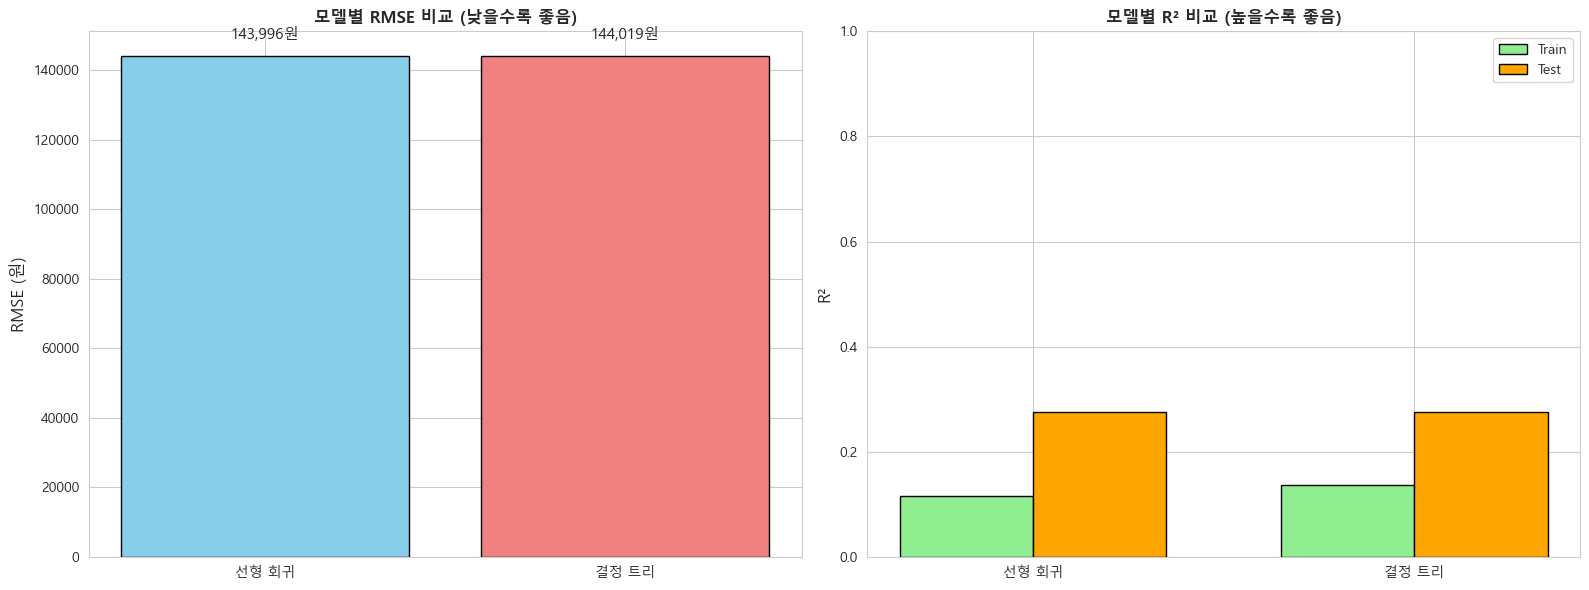

In [37]:
# 모델 성능 비교
comparison = pd.DataFrame({
    '모델': ['선형 회귀', '결정 트리'],
    'RMSE (Test)': [test_rmse, test_rmse_dt],
    'MAE (Test)': [test_mae, test_mae_dt],
    'R² (Test)': [test_r2, test_r2_dt],
    'R² (Train)': [train_r2, train_r2_dt]
})

print("\n모델 성능 비교:")
print(comparison.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE 비교
axes[0].bar(['선형 회귀', '결정 트리'], [test_rmse, test_rmse_dt], 
            color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0].set_ylabel('RMSE (원)', fontsize=12)
axes[0].set_title('모델별 RMSE 비교 (낮을수록 좋음)', fontsize=12, fontweight='bold')
for i, v in enumerate([test_rmse, test_rmse_dt]):
    axes[0].text(i, v + 5000, f'{v:,.0f}원', ha='center', fontsize=11)

# R² 비교
x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [train_r2, train_r2_dt], width, label='Train', 
            color='lightgreen', edgecolor='black')
axes[1].bar(x + width/2, [test_r2, test_r2_dt], width, label='Test', 
            color='orange', edgecolor='black')
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('모델별 R² 비교 (높을수록 좋음)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['선형 회귀', '결정 트리'])
axes[1].legend()
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 5.4 예측 vs 실제 비교

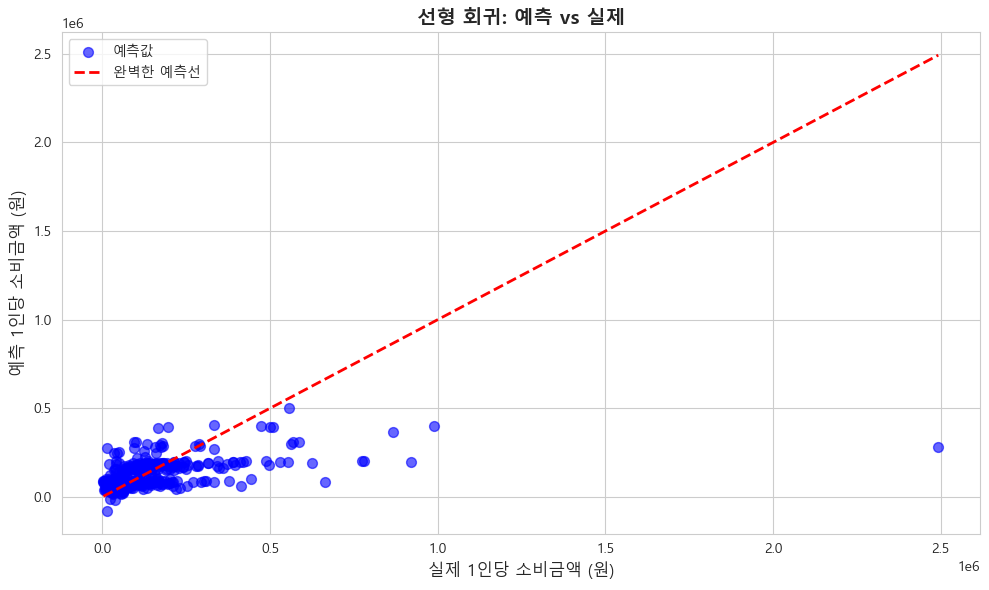


해석:
  - 점들이 빨간 선에 가까울수록 예측이 정확함
  - 흩어진 정도가 예측 오차를 나타냄


In [38]:
# 선형 회귀 모델의 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50, c='blue', label='예측값')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='완벽한 예측선')
plt.xlabel('실제 1인당 소비금액 (원)', fontsize=12)
plt.ylabel('예측 1인당 소비금액 (원)', fontsize=12)
plt.title('선형 회귀: 예측 vs 실제', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - 점들이 빨간 선에 가까울수록 예측이 정확함")
print("  - 흩어진 정도가 예측 오차를 나타냄")

## 6. 결론 및 인사이트

In [39]:
print("="*80)
print("                         프로젝트 주요 인사이트")
print("="*80)

print("\n[1] 데이터 특성")
print(f"  • 총 {len(df)}건의 여행 데이터 분석 (동부권)")
print(f"  • 20-30대 여성이 주요 고객층 (약 70%)")
print(f"  • 평균 체류기간: {df['stay_days'].mean():.1f}일")
print(f"  • 평균 1인당 소비: {df['per_person_spending'].mean():,.0f}원")

print("\n[2] 주요 발견사항")
print("  • 연령대별 소비 차이 존재")
highest_age = df.groupby('AGE_GRP')['per_person_spending'].mean().idxmax()
print(f"    → {highest_age}대가 가장 높은 평균 소비금액")
print("  • 체류 기간과 소비금액의 관계")
corr_stay = df['stay_days'].corr(df['per_person_spending'])
print(f"    → 상관계수 {corr_stay:.3f}")

print("\n[3] 모델 성능")
print(f"  • 선형 회귀 - Test RMSE: {test_rmse:,.0f}원, R²: {test_r2:.4f}")
print(f"  • 결정 트리 - Test RMSE: {test_rmse_dt:,.0f}원, R²: {test_r2_dt:.4f}")
if test_r2 > test_r2_dt:
    print("  → 선형 회귀가 더 나은 일반화 성능")
else:
    print("  → 결정 트리가 더 나은 예측 성능")

print("\n[4] 한계점")
print("  • 단일 권역(수도권) 데이터만 포함")
print("  • 계절 데이터 제한적 (여름-가을만)")
print("  • 피쳐 수 제한적 (추가 변수 고려 필요)")

print("\n[5] 개선 방향")
print("  • 전체 권역 데이터 통합 분석")
print("  • 연중 데이터 수집으로 계절성 분석 강화")
print("  • 목적지별, 활동 유형별 세분화 분석")
print("  • 더 복잡한 모델(앙상블) 시도")

print("="*80)

                         프로젝트 주요 인사이트

[1] 데이터 특성
  • 총 2560건의 여행 데이터 분석 (동부권)
  • 20-30대 여성이 주요 고객층 (약 70%)
  • 평균 체류기간: 1.4일
  • 평균 1인당 소비: 113,185원

[2] 주요 발견사항
  • 연령대별 소비 차이 존재
    → 20대가 가장 높은 평균 소비금액
  • 체류 기간과 소비금액의 관계
    → 상관계수 0.346

[3] 모델 성능
  • 선형 회귀 - Test RMSE: 143,996원, R²: 0.2750
  • 결정 트리 - Test RMSE: 144,019원, R²: 0.2748
  → 선형 회귀가 더 나은 일반화 성능

[4] 한계점
  • 단일 권역(동부권) 데이터만 포함
  • 계절 데이터 제한적 (여름-가을만)
  • 피쳐 수 제한적 (추가 변수 고려 필요)

[5] 개선 방향
  • 전체 권역 데이터 통합 분석
  • 연중 데이터 수집으로 계절성 분석 강화
  • 목적지별, 활동 유형별 세분화 분석
  • 더 복잡한 모델(앙상블) 시도


## 7. 부록: 추가 분석 (선택사항)

In [ ]:
# 소비 카테고리별 비중
total_by_category = {
    '활동': df['activity_spending'].sum(),
    '사전': df['advance_spending'].sum(),
    '숙박': df['lodge_spending'].sum(),
    '이동': df['movement_spending'].sum()
}

plt.figure(figsize=(10, 10))
plt.pie(total_by_category.values(), labels=total_by_category.keys(), 
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('소비 카테고리별 비중', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n카테고리별 총 소비:")
for cat, amount in total_by_category.items():
    print(f"  {cat}: {amount:,.0f}원 ({amount/sum(total_by_category.values())*100:.1f}%)")

In [ ]:
# 샘플 예측
print("="*80)
print("                      샘플 예측 예시")
print("="*80)

# 예시 입력
sample_cases = [
    {'연령대': 20, '성별': '여성', '동반자수': 1, '체류기간': 1},
    {'연령대': 30, '성별': '남성', '동반자수': 2, '체류기간': 2},
    {'연령대': 40, '성별': '여성', '동반자수': 0, '체류기간': 0}
]

for i, case in enumerate(sample_cases, 1):
    # 인코딩
    age = case['연령대']
    gender = 1 if case['성별'] == '여성' else 0
    companions = case['동반자수']
    days = case['체류기간']
    
    # 예측
    X_sample = np.array([[age, gender, companions, days]])
    pred_lr = lr_model.predict(X_sample)[0]
    pred_dt = dt_model.predict(X_sample)[0]
    
    print(f"\n[Case {i}]")
    print(f"  입력: {case['연령대']}대 {case['성별']}, 동반자 {case['동반자수']}명, {case['체류기간']}일")
    print(f"  선형회귀 예측: {pred_lr:,.0f}원")
    print(f"  결정트리 예측: {pred_dt:,.0f}원")

print("\n" + "="*80)